In [47]:
from parse import *
import networkx as nx
from utils import *
import sys
from collections import defaultdict

In [93]:
def solve(G):
    """
    Args:
        G: networkx.Graph

    Returns:
        T: networkx.Graph
    """
    min_tree = nx.Graph()
    min_cost = float('inf')

    # if by luck there's a node connecting to all other verts, return it 
    for node in G.nodes:
        if len(list(nx.neighbors(G, node))) == nx.number_of_nodes(G) - 1:
            min_tree.add_node(node)
            return min_tree
            
#     all_degrees = G.degree(G.nodes) # dict of (node: deg) items
#     for node, deg in all_degrees:
#         if deg == nx.number_of_nodes(G) - 1:
#             min_tree.add_node(node)
#             return min_tree

    start_vertices = starting_point(G)

    # run greedy alg on all starting vertex candidates
    for start_vertex in start_vertices:
        curr_tree = greedy_find_min_tree(G, start_vertex)
        curr_cost = average_pairwise_distance_fast(curr_tree)
        if curr_cost < min_cost:
            min_cost = curr_cost
            min_tree = curr_tree

    return min_tree

# vertices w more than n*DENSE_THRESHOLD neighbors is considered dense
DENSE_THRESHOLD = 0.75
SPARSE_THRESHOLD = 0.25

def starting_point(G):
    """ 
    picks starting point depending on sparcity of graph
    """
    result = []
    # (node, degree) pairs
    all_degrees = G.degree(G.nodes)

    # maps from degree to list of nodes w that degree
    deg_to_nodes = defaultdict(list)
    for node, deg in all_degrees:
        deg_to_nodes[deg].append(node)

    max_deg = max(deg_to_nodes)
    min_deg = min(deg_to_nodes)

    # include sparse nodes
    if min_deg <= (len(G) * SPARSE_THRESHOLD):
        if min_deg == 1:
            leaf = deg_to_nodes[min_deg][0] # could optimize this more
            leaf_neighbor = list(G[leaf])[0] 
            result.append(leaf_neighbor)  
        else:
            result.append(deg_to_nodes[min_deg][0])

    # include dense nodes
    if max_deg >= (len(G) * DENSE_THRESHOLD):
        result.append(deg_to_nodes[max_deg][0])  # could optimize this more
    # if there's neither dense nor sparse nodes, default to starting at densest node
    else:
        result.append(deg_to_nodes[max_deg][0])

    return result


def greedy_find_min_tree(G, start_node):
    """
    a greedy alg akin to prim's
    """
    tree = nx.Graph()
    tree.add_node(start_node)
    tree_nodes = [start_node]
    reachable_nodes = {start_node}
    itercount = 0

    #until found the first dominating set
    while not nx.is_dominating_set(G, tree.nodes):
        itercount += 1
        # update the min tree
        min_tree = tree
        min_cost = float('inf')
        min_node = None
        for node in tree_nodes:
            neighbors =  nx.neighbors(G, node)
            for neighbor_node in neighbors:
                if (neighbor_node not in tree_nodes) :
                    temp_tree = tree.copy()
                    edge_weight  = G[node][neighbor_node]['weight']
                    temp_tree.add_edge(node, neighbor_node)
                    temp_tree[node][neighbor_node]['weight'] = edge_weight
                    cost = average_pairwise_distance_fast(temp_tree)
                    if (cost < min_cost):
                        min_cost = cost
                        min_tree = temp_tree
                        min_node = neighbor_node

        tree = min_tree
        tree_nodes.append(min_node)
        reachable_nodes = reachable_nodes | {min_node}

        #updating reachable nodes
        for node in tree_nodes:
            neighbors = set(nx.neighbors(G, node))
            reachable_nodes = reachable_nodes | neighbors
    
    return tree

In [94]:
filenum = "235"
path = "./inputs/small-{}.in".format(filenum)
G = read_input_file(path)
T = solve(G)

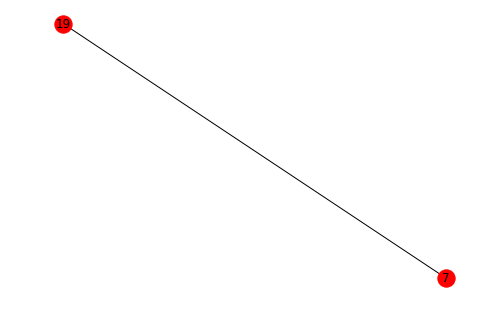

In [95]:
nx.draw(T, with_labels=True)

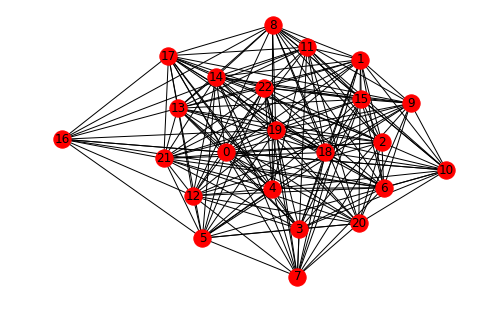

In [70]:
nx.draw(G, with_labels=True)

In [96]:
nx.is_dominating_set(G, T.nodes)

True

In [97]:
nx.is_tree(T)

True

In [75]:
nx.number_of_nodes(G)

23

In [72]:
G.degree[19]

22

In [85]:
l = list(nx.neighbors(G, 19))

In [86]:
l.sort()

In [87]:
l

[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]

In [92]:
list(nx.nodes_with_selfloops(G))

[14, 9, 21, 12, 19, 7, 18, 8, 3, 22, 4, 0, 6, 13, 20, 17]